In [7]:
import pandas as pd
import numpy as np

# Load your dataset
df = pd.read_csv("../data/data_science_job_posts_2025_clean.csv")

# Keep relevant columns
df = df[['job_title', 'skills', 'company', 'company_size', 'salary', 'location']]

# Drop rows with missing key fields
df = df.dropna(subset=['job_title', 'skills', 'company', 'company_size', 'salary', 'location'])

print(df.head())
print(df.shape)


        job_title                                             skills  \
0  data scientist  ['spark', 'r', 'python', 'scala', 'machine lea...   
1  data scientist  ['spark', 'r', 'python', 'sql', 'machine learn...   
2  data scientist  ['aws', 'git', 'python', 'docker', 'sql', 'mac...   
3  data scientist                             ['sql', 'r', 'python']   
4  data scientist                                                 []   

       company company_size               salary  \
0  company_003     €352.44B  €100,472 - €200,938   
1  company_005      155,030             €118,733   
2  company_007       25,930   €94,987 - €159,559   
3  company_008       34,690  €112,797 - €194,402   
4  company_009        1,800  €114,172 - €228,337   

                                            location  
0                             Grapevine, TX . Hybrid  
1                            Fort Worth, TX . Hybrid  
2  Austin, TX . Toronto, Ontario, Canada . Kirkla...  
3  Chicago, IL . Scottsdale, AZ . 

In [8]:
# Clean "['python', 'sql']" → "python sql"
def clean_skills(s):
    s = str(s)
    s = s.replace("[", "").replace("]", "").replace("'", "")
    s = s.replace(",", " ")
    return s

df['skills_clean'] = df['skills'].apply(clean_skills)

# Parse salary: handle "€70,000-€90,000" or "€85,000"
def parse_salary_to_number(s):
    s = str(s).replace("€", "").replace(" ", "")
    # Range: "70000-90000"
    if "-" in s:
        parts = s.split("-")
        try:
            low = float(parts[0].replace(",", ""))
            high = float(parts[1].replace(",", ""))
            return (low + high) / 2.0
        except:
            return np.nan
    else:
        try:
            return float(s.replace(",", ""))
        except:
            return np.nan

df['salary_usd'] = df['salary'].apply(parse_salary_to_number)
df = df.dropna(subset=['salary_usd'])

print(df[['salary', 'salary_usd']].head())


                salary  salary_usd
0  €100,472 - €200,938    150705.0
1             €118,733    118733.0
2   €94,987 - €159,559    127273.0
3  €112,797 - €194,402    153599.5
4  €114,172 - €228,337    171254.5


In [32]:
# Make sure df has clean 0..N-1 index so we can build selection vectors easily
df = df.reset_index(drop=True)
n_jobs = len(df)


In [9]:
def company_size_group(size):
    size_str = str(size)
    
    # Very big ones like "€352.44B" → treat as large
    if "€" in size_str or "b" in size_str.lower() or "m" in size_str.lower():
        return "large"
    
    cleaned = size_str.replace(",", "")
    try:
        n = int(cleaned)
    except:
        return "unknown"
    
    if n < 1000:
        return "small"
    elif n < 10000:
        return "medium"
    else:
        return "large"

df['company_size_group'] = df['company_size'].apply(company_size_group)

# Drop unknowns for simplicity
df = df[df['company_size_group'] != 'unknown']

print(df['company_size_group'].value_counts())


company_size_group
large     544
small     205
medium    172
Name: count, dtype: int64


In [10]:
# This is where we MAKE the bias explicit:
# large companies get 1.3x boost, medium 1.1x, small normal (1.0)
def company_size_bias_factor(group):
    if group == "large":
        return 1.3     # strongest boost
    elif group == "medium":
        return 1.1
    else:  # small
        return 1.0

df['bias_factor'] = df['company_size_group'].apply(company_size_bias_factor)


In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=5000)
X_skills = vectorizer.fit_transform(df['skills_clean'])


In [42]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

def recommend_biased_with_rank(user_skills, desired_salary=None, desired_location=None, top_k=10):
    # 1) Skill similarity
    user_skills_clean = clean_skills(user_skills)
    query_vec = vectorizer.transform([user_skills_clean])
    skill_sim = cosine_similarity(query_vec, X_skills).flatten()  # shape: (n_jobs,)
    
    # 2) Salary score
    if desired_salary is not None:
        salary_diff = np.abs(df['salary_usd'] - desired_salary)
        salary_score = np.exp(-salary_diff / df['salary_usd'].median())
    else:
        salary_score = np.ones(len(df))
    
    # 3) Location score
    if desired_location is not None:
        loc_lower = df['location'].astype(str).str.lower()
        desired_loc_lower = desired_location.lower()
        location_score = np.where(loc_lower.str.contains(desired_loc_lower), 1.0, 0.5)
    else:
        location_score = np.ones(len(df))
    
    # 4) Base relevance score
    w_skill = 0.6
    w_salary = 0.25
    w_location = 0.15
    
    base_score = (
        w_skill * skill_sim +
        w_salary * salary_score +
        w_location * location_score
    )
    
    # 5) Apply company size bias (favor large companies)
    biased_score = base_score * df['bias_factor'].values
    
    # 6) Sort and take top-k
    top_idx = np.argsort(biased_score)[-top_k:][::-1]
    
    # 7) Build ranked result table
    result = df.iloc[top_idx].copy()
    result['base_score'] = base_score[top_idx]
    result['final_score'] = biased_score[top_idx]
    result['rank'] = range(1, len(result) + 1)
    
    # Order columns nicely
    return result[[
        'rank',
        'job_title',
        'company',
        'company_size',
        'company_size_group',
        'location',
        'salary_usd',
        'skills_clean',
        'base_score',
        'final_score'
    ]]


In [43]:
biased_results = recommend_biased_with_rank(
    user_skills="python sql machine learning",
    desired_salary=90000,
    desired_location="germany",
    top_k=10
)
biased_results


,rank,job_title,company,company_size,company_size_group,location,salary_usd,skills_clean,base_score,final_score
659,1,data scientist,company_310,"20,010",large,"Homestead, FL",96180.0,sql machine learning r python,0.913973,1.188165
881,2,data scientist,company_244,"290,800",large,"London, England, United Kingdom",97625.0,sql machine learning python,0.911466,1.184906
911,3,data scientist,company_881,"110,010",large,"Singapore, Singapore",80543.5,sql machine learning r python,0.908326,1.180823
281,4,data scientist,company_579,"39,879",large,"Philadelphia, PA",100472.0,sql machine learning r python,0.906603,1.178583
532,5,data scientist,company_318,"55,030",large,United States,100472.0,sql machine learning r python,0.906603,1.178583
746,6,data scientist,company_310,"20,030",large,"Annapolis Junction, MD",101339.5,sql machine learning r python,0.905141,1.176683
457,7,data scientist,company_896,"100,050",large,"Dallas, TX",75815.0,sql machine learning python,0.900410,1.170533
29,8,machine learning engineer,company_052,"26,950",large,"Amsterdam, North Holland, Netherlands",72515.0,sql machine learning python,0.895045,1.163559
253,9,data scientist,company_490,"83,550",large,"Overland Park, KS . Frisco, TX . Bellevue, WA ...",110517.5,sql machine learning r python,0.890228,1.157296
13,10,data scientist,company_031,"128,890",large,"Titusville, NJ . Titusville, New Jersey, Unite...",115083.0,sql machine learning r python,0.883174,1.148126


In [57]:
# Fairness reweighting factors
fair_factor_map = {
    "large": 0.9,
    "medium": 1.0,
    "small": 1.0
}

df['fair_factor'] = df['company_size_group'].map(fair_factor_map)


In [58]:
def recommend_fair_with_rank(user_skills, desired_salary=None, desired_location=None, top_k=10):
    # 1) Skill similarity
    user_skills_clean = clean_skills(user_skills)
    query_vec = vectorizer.transform([user_skills_clean])
    skill_sim = cosine_similarity(query_vec, X_skills).flatten()
    
    # 2) Salary score
    if desired_salary is not None:
        salary_diff = np.abs(df['salary_usd'] - desired_salary)
        salary_score = np.exp(-salary_diff / df['salary_usd'].median())
    else:
        salary_score = np.ones(len(df))
    
    # 3) Location score
    if desired_location is not None:
        loc_lower = df['location'].astype(str).str.lower()
        desired_loc_lower = desired_location.lower()
        location_score = np.where(loc_lower.str.contains(desired_loc_lower), 1.0, 0.5)
    else:
        location_score = np.ones(len(df))
    
    # 4) Base relevance score (same as biased)
    w_skill = 0.6
    w_salary = 0.25
    w_location = 0.15
    
    base_score = (
        w_skill * skill_sim +
        w_salary * salary_score +
        w_location * location_score
    )
    
    # 5) Apply FAIR factor (downweight large)
    fair_score = base_score * df['fair_factor'].values
    
    # 6) Sort and take top-k
    top_idx = np.argsort(fair_score)[-top_k:][::-1]
    
    # 7) Build ranked result table
    result = df.iloc[top_idx].copy()
    result['base_score'] = base_score[top_idx]
    result['final_score'] = fair_score[top_idx]
    result['rank'] = range(1, len(result) + 1)
    
    return result[[
        'rank',
        'job_title',
        'company',
        'company_size',
        'company_size_group',
        'location',
        'salary_usd',
        'skills_clean',
        'base_score',
        'final_score'
    ]]


In [59]:
fair_results = recommend_fair_with_rank(
    user_skills="python sql machine learning",
    desired_salary=90000,
    desired_location="germany",
    top_k=10
)
fair_results


,rank,job_title,company,company_size,company_size_group,location,salary_usd,skills_clean,base_score,final_score
311,1,data scientist,company_643,751,small,"Minneapolis, MN . Hybrid",103871.0,sql machine learning r python,0.900927,0.900927
536,2,data scientist,company_974,"2,280",medium,"Toronto, Ontario, Canada",75103.0,sql machine learning python,0.899242,0.899242
351,3,data scientist,company_746,90,small,United States,105039.5,sql machine learning r python,0.899008,0.899008
482,4,data scientist,company_746,90,small,United States,128270.0,sql machine learning python,0.864070,0.864070
273,5,data scientist,company_555,"3,040",medium,"Boston, MA",141571.0,sql machine learning r python,0.846577,0.846577
172,6,data scientist,company_324,"2,540",medium,United States . On-site,143853.0,sql machine learning r python,0.843742,0.843742
27,7,data scientist,company_050,807,small,"San Francisco, CA",150707.0,sql machine learning r python,0.835508,0.835508
162,8,data scientist,company_306,90,small,"Fort Meade, MD . Fort Meade, Maryland, Birleşi...",152987.0,sql machine learning r python,0.832859,0.832859
177,9,data scientist,company_340,750,small,"San Jose, CA . Hybrid",153602.5,sql machine learning r python,0.832151,0.832151
247,10,data scientist,company_340,750,small,"San Jose, CA . Hybrid",153605.5,sql machine learning r python,0.832148,0.832148


In [60]:
def exposure_by_size(results_df):
    counts = results_df['company_size_group'].value_counts(normalize=True)
    return counts.reindex(['small', 'medium', 'large']).fillna(0.0)

top_k = 10

biased_results = recommend_biased_with_rank(
    user_skills="python sql machine learning",
    desired_salary=90000,
    desired_location="germany",
    top_k=top_k
)

fair_results = recommend_fair_with_rank(
    user_skills="python sql machine learning",
    desired_salary=90000,
    desired_location="germany",
    top_k=top_k
)

exp_biased = exposure_by_size(biased_results)
exp_fair = exposure_by_size(fair_results)

print("Biased recommender exposure (top-10):")
print(exp_biased)

print("\nFair recommender exposure (top-10):")
print(exp_fair)


Biased recommender exposure (top-10):
company_size_group
small     0.0
medium    0.0
large     1.0
Name: proportion, dtype: float64

Fair recommender exposure (top-10):
company_size_group
small     0.7
medium    0.3
large     0.0
Name: proportion, dtype: float64


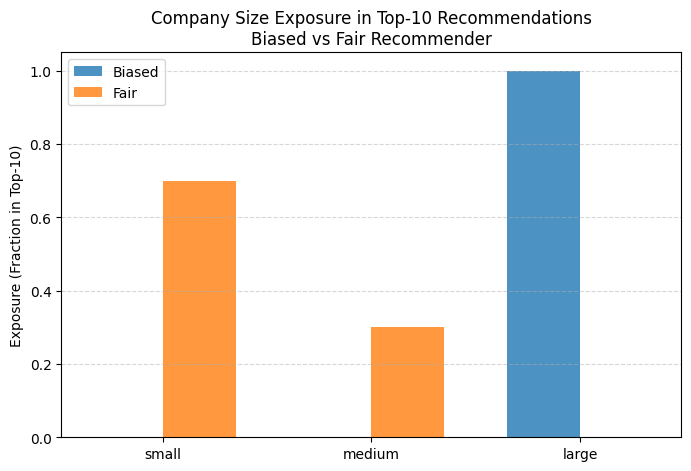

In [61]:
import matplotlib.pyplot as plt
import numpy as np

groups = ['small', 'medium', 'large']
biased_vals = [exp_biased[g] for g in groups]
fair_vals = [exp_fair[g] for g in groups]

x = np.arange(len(groups))
width = 0.35

plt.figure(figsize=(8,5))
plt.bar(x - width/2, biased_vals, width, label="Biased", alpha=0.8)
plt.bar(x + width/2, fair_vals, width, label="Fair", alpha=0.8)

plt.xticks(x, groups)
plt.ylabel("Exposure (Fraction in Top-10)")
plt.title("Company Size Exposure in Top-10 Recommendations\nBiased vs Fair Recommender")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()


In [62]:
#binary labels
top_k = 10

# get index positions of recommended jobs
biased_indices = biased_results.index
fair_indices   = fair_results.index

# create binary label arrays
df['biased_pred'] = df.index.isin(biased_indices).astype(int)
df['fair_pred']   = df.index.isin(fair_indices).astype(int)

# sensitive attribute
sensitive = df['company_size_group']


In [63]:
#compute selection rate
from fairlearn.metrics import selection_rate, MetricFrame

sr_biased = MetricFrame(
    metrics=selection_rate,
    y_true=df['biased_pred'],    # y_true not needed for selection rate
    y_pred=df['biased_pred'],
    sensitive_features=sensitive
)

print("Selection Rate (Biased):")
print(sr_biased.by_group)


Selection Rate (Biased):
company_size_group
large     0.018382
medium    0.000000
small     0.000000
Name: selection_rate, dtype: float64


In [64]:
sr_fair = MetricFrame(
    metrics=selection_rate,
    y_true=df['fair_pred'],
    y_pred=df['fair_pred'],
    sensitive_features=sensitive
)

print("\nSelection Rate (Fair):")
print(sr_fair.by_group)



Selection Rate (Fair):
company_size_group
large     0.000000
medium    0.017442
small     0.034146
Name: selection_rate, dtype: float64


In [ ]:
#Metric 1 : Exposure Per Group (Rank-aware)
import numpy as np
import pandas as pd

def compute_exposure(results_df, group_col='company_size_group'):
    exposure_scores = []
    for rank in results_df['rank']:
        exposure_scores.append(1 / np.log2(rank + 1))  # discounted exposure
    
    results_df = results_df.copy()
    results_df['exposure'] = exposure_scores
    
    return results_df.groupby(group_col)['exposure'].sum()


In [86]:
biased_exposure = compute_exposure(biased_results)
fair_exposure   = compute_exposure(fair_results)

print("Biased Exposure:\n", biased_exposure)
print("Fair Exposure:\n", fair_exposure)


Biased Exposure:
 company_size_group
large    4.543559
Name: exposure, dtype: float64
Fair Exposure:
 company_size_group
medium    1.37399
small     3.16957
Name: exposure, dtype: float64


In [ ]:
#Metric 2: Proportional fairness error
# group distribution in full dataset
pop_dist = df['company_size_group'].value_counts(normalize=True)

def PFE(exposure, pop_dist):
    exposure_norm = exposure / exposure.sum()
    return (exposure_norm - pop_dist).abs()

pfe_biased = PFE(biased_exposure, pop_dist)
pfe_fair   = PFE(fair_exposure,   pop_dist)

print("PFE Biased:\n", pfe_biased)
print("\nPFE Fair:\n", pfe_fair)


PFE Biased:
 company_size_group
large     0.409338
medium         NaN
small          NaN
dtype: float64

PFE Fair:
 company_size_group
large          NaN
medium    0.115650
small     0.475012
dtype: float64


In [89]:
#Recommendation Diversity
def diversity(results_df):
    return results_df['company'].nunique()

print("Baseline diversity:", diversity(biased_results))
print("Fair diversity:", diversity(fair_results))


Baseline diversity: 9
Fair diversity: 8


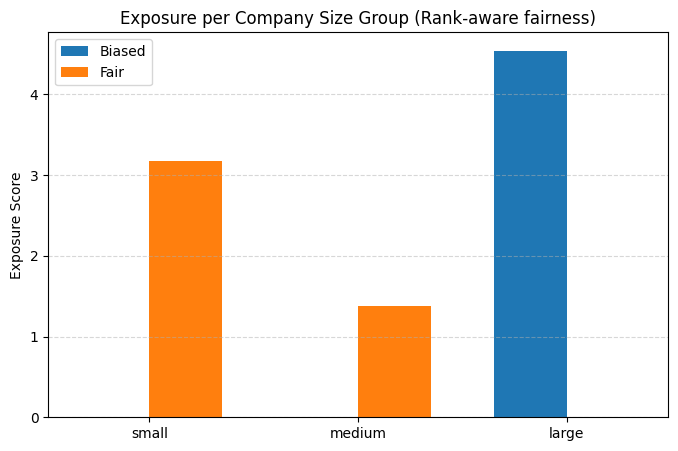

In [90]:
#Exposure bar chart Rank aware
import matplotlib.pyplot as plt

groups = ['small','medium','large']
biased_vals = [biased_exposure.get(g,0) for g in groups]
fair_vals   = [fair_exposure.get(g,0)   for g in groups]

x = np.arange(len(groups))
w = 0.35

plt.figure(figsize=(8,5))
plt.bar(x - w/2, biased_vals, w, label="Biased")
plt.bar(x + w/2, fair_vals,   w, label="Fair")
plt.xticks(x, groups)
plt.title("Exposure per Company Size Group (Rank-aware fairness)")
plt.ylabel("Exposure Score")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()


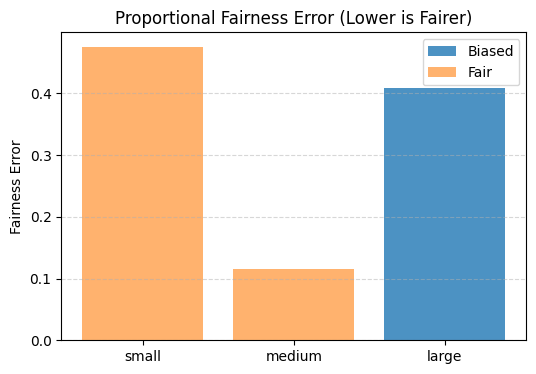

In [91]:
#PFE chart
plt.figure(figsize=(6,4))
plt.bar(groups, pfe_biased[groups], label="Biased", alpha=0.8)
plt.bar(groups, pfe_fair[groups],   label="Fair", alpha=0.6)
plt.title("Proportional Fairness Error (Lower is Fairer)")
plt.ylabel("Fairness Error")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()


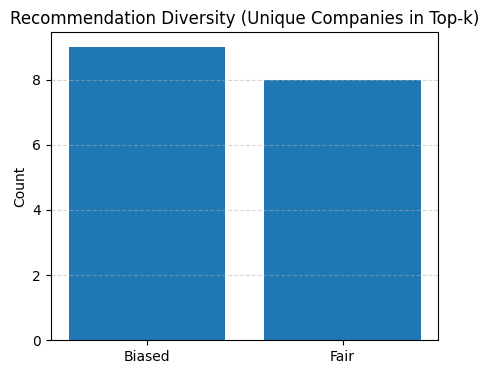

In [92]:
#Diversity comparision
plt.figure(figsize=(5,4))
plt.bar(['Biased','Fair'], [diversity(biased_results),
                            diversity(fair_results)])
plt.title("Recommendation Diversity (Unique Companies in Top-k)")
plt.ylabel("Count")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()
